In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from wordcloud import WordCloud
import os

In [2]:
# Define the folder containing the processed CSV files
input_folder = "processed_data"

In [3]:
# Get the list of all CSV files in the folder
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Create a dictionary to hold the DataFrames
dfs = {}

# Loop through the files and create a DataFrame for each one
for file in csv_files:
    file_path = os.path.join(input_folder, file)
    
    # Load the CSV into a DataFrame
    df = pd.read_csv(file_path)
    
    # Add the DataFrame to the dictionary using the filename (without extension) as the key
    dfs[file] = df

    print(f"Created DataFrame for file: {file}")

Created DataFrame for file: Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=True_use_stemming=False.csv


In [4]:
dfs["Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=True_use_stemming=False.csv"].head()

,Category,Text
0,Accountant,education executive leadership university bach...
1,Accountant,accountant work experience company name accoun...
2,Accountant,frank senior accountant u office peach tree le...
3,Accountant,place birth nationality accountant pacific ave...
4,Accountant,greet senior accountant year experience best a...


In [5]:
count_vect = CountVectorizer(
    lowercase=True,
    binary = False,
    # stop_words = list(stop_words),      # TODO could be not useful, we already remove stop words in preprocess_text
    # ngram_range=(1,2),               # Considers unigrams and bigrams
    # max_df = 0.85,                    # Ignores words appearing in more than 85% of documents (too common)
    # min_df = 2,                       # Keeps words appearing in at least 2 documents (filters rare words)
)

In [6]:
# Split data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (12698,)
Validation data size: (3175,)


In [7]:
print("NaN in X_train:\n", X_train.isna().sum())
print("NaN in X_test:\n", X_test.isna().sum())

NaN in X_train:
 1
NaN in X_test:
 0


In [8]:
X_train = X_train.fillna("")
X_test = X_test.fillna("")

In [9]:
conuntvectorizer_train = count_vect.fit_transform(X_train).astype(float)
conuntvectorizer_test = count_vect.transform(X_test).astype(float)

In [10]:
tfidf_transformer = TfidfTransformer()

In [11]:
X_train_tfidf = tfidf_transformer.fit_transform(conuntvectorizer_train)
X_test_tfidf = tfidf_transformer.fit_transform(conuntvectorizer_test)

# using grid search for find optimal values for RF classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RFC = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train_tfidf, y_train)

print(grid_search.best_params_)

In [12]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=8, criterion='gini')
RF_Model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

In [13]:
prediction=RF_Model.predict(X_test_tfidf)
prediction

array(['Network Security Engineer', 'Accountant', 'Business Analyst', ...,
       'Health and Fitness', 'Human Resources',
       'Network Security Engineer'], dtype=object)

In [14]:
print("training Score: {:.2f}".format(RF_Model.score(X_train_tfidf, y_train)))
print("test Score: {:.2f}".format(RF_Model.score(X_test_tfidf, y_test)))

training Score: 0.73
test Score: 0.66


In [15]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,prediction))

                           precision    recall  f1-score   support

               Accountant       0.53      0.98      0.69        94
                 Advocate       0.85      0.70      0.77        82
              Agriculture       0.89      0.80      0.84        71
                  Apparel       0.69      0.84      0.76        83
             Architecture       0.90      0.52      0.66        69
                     Arts       0.84      0.18      0.30        87
               Automobile       0.97      0.54      0.70        70
                 Aviation       0.77      0.95      0.85        91
                      BPO       0.00      0.00      0.00        45
                  Banking       0.74      0.78      0.76        86
               Blockchain       0.00      0.00      0.00         9
Building and Construction       0.61      0.82      0.70        91
         Business Analyst       0.46      0.61      0.53        92
                     Chef       1.00      0.43      0.61     

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

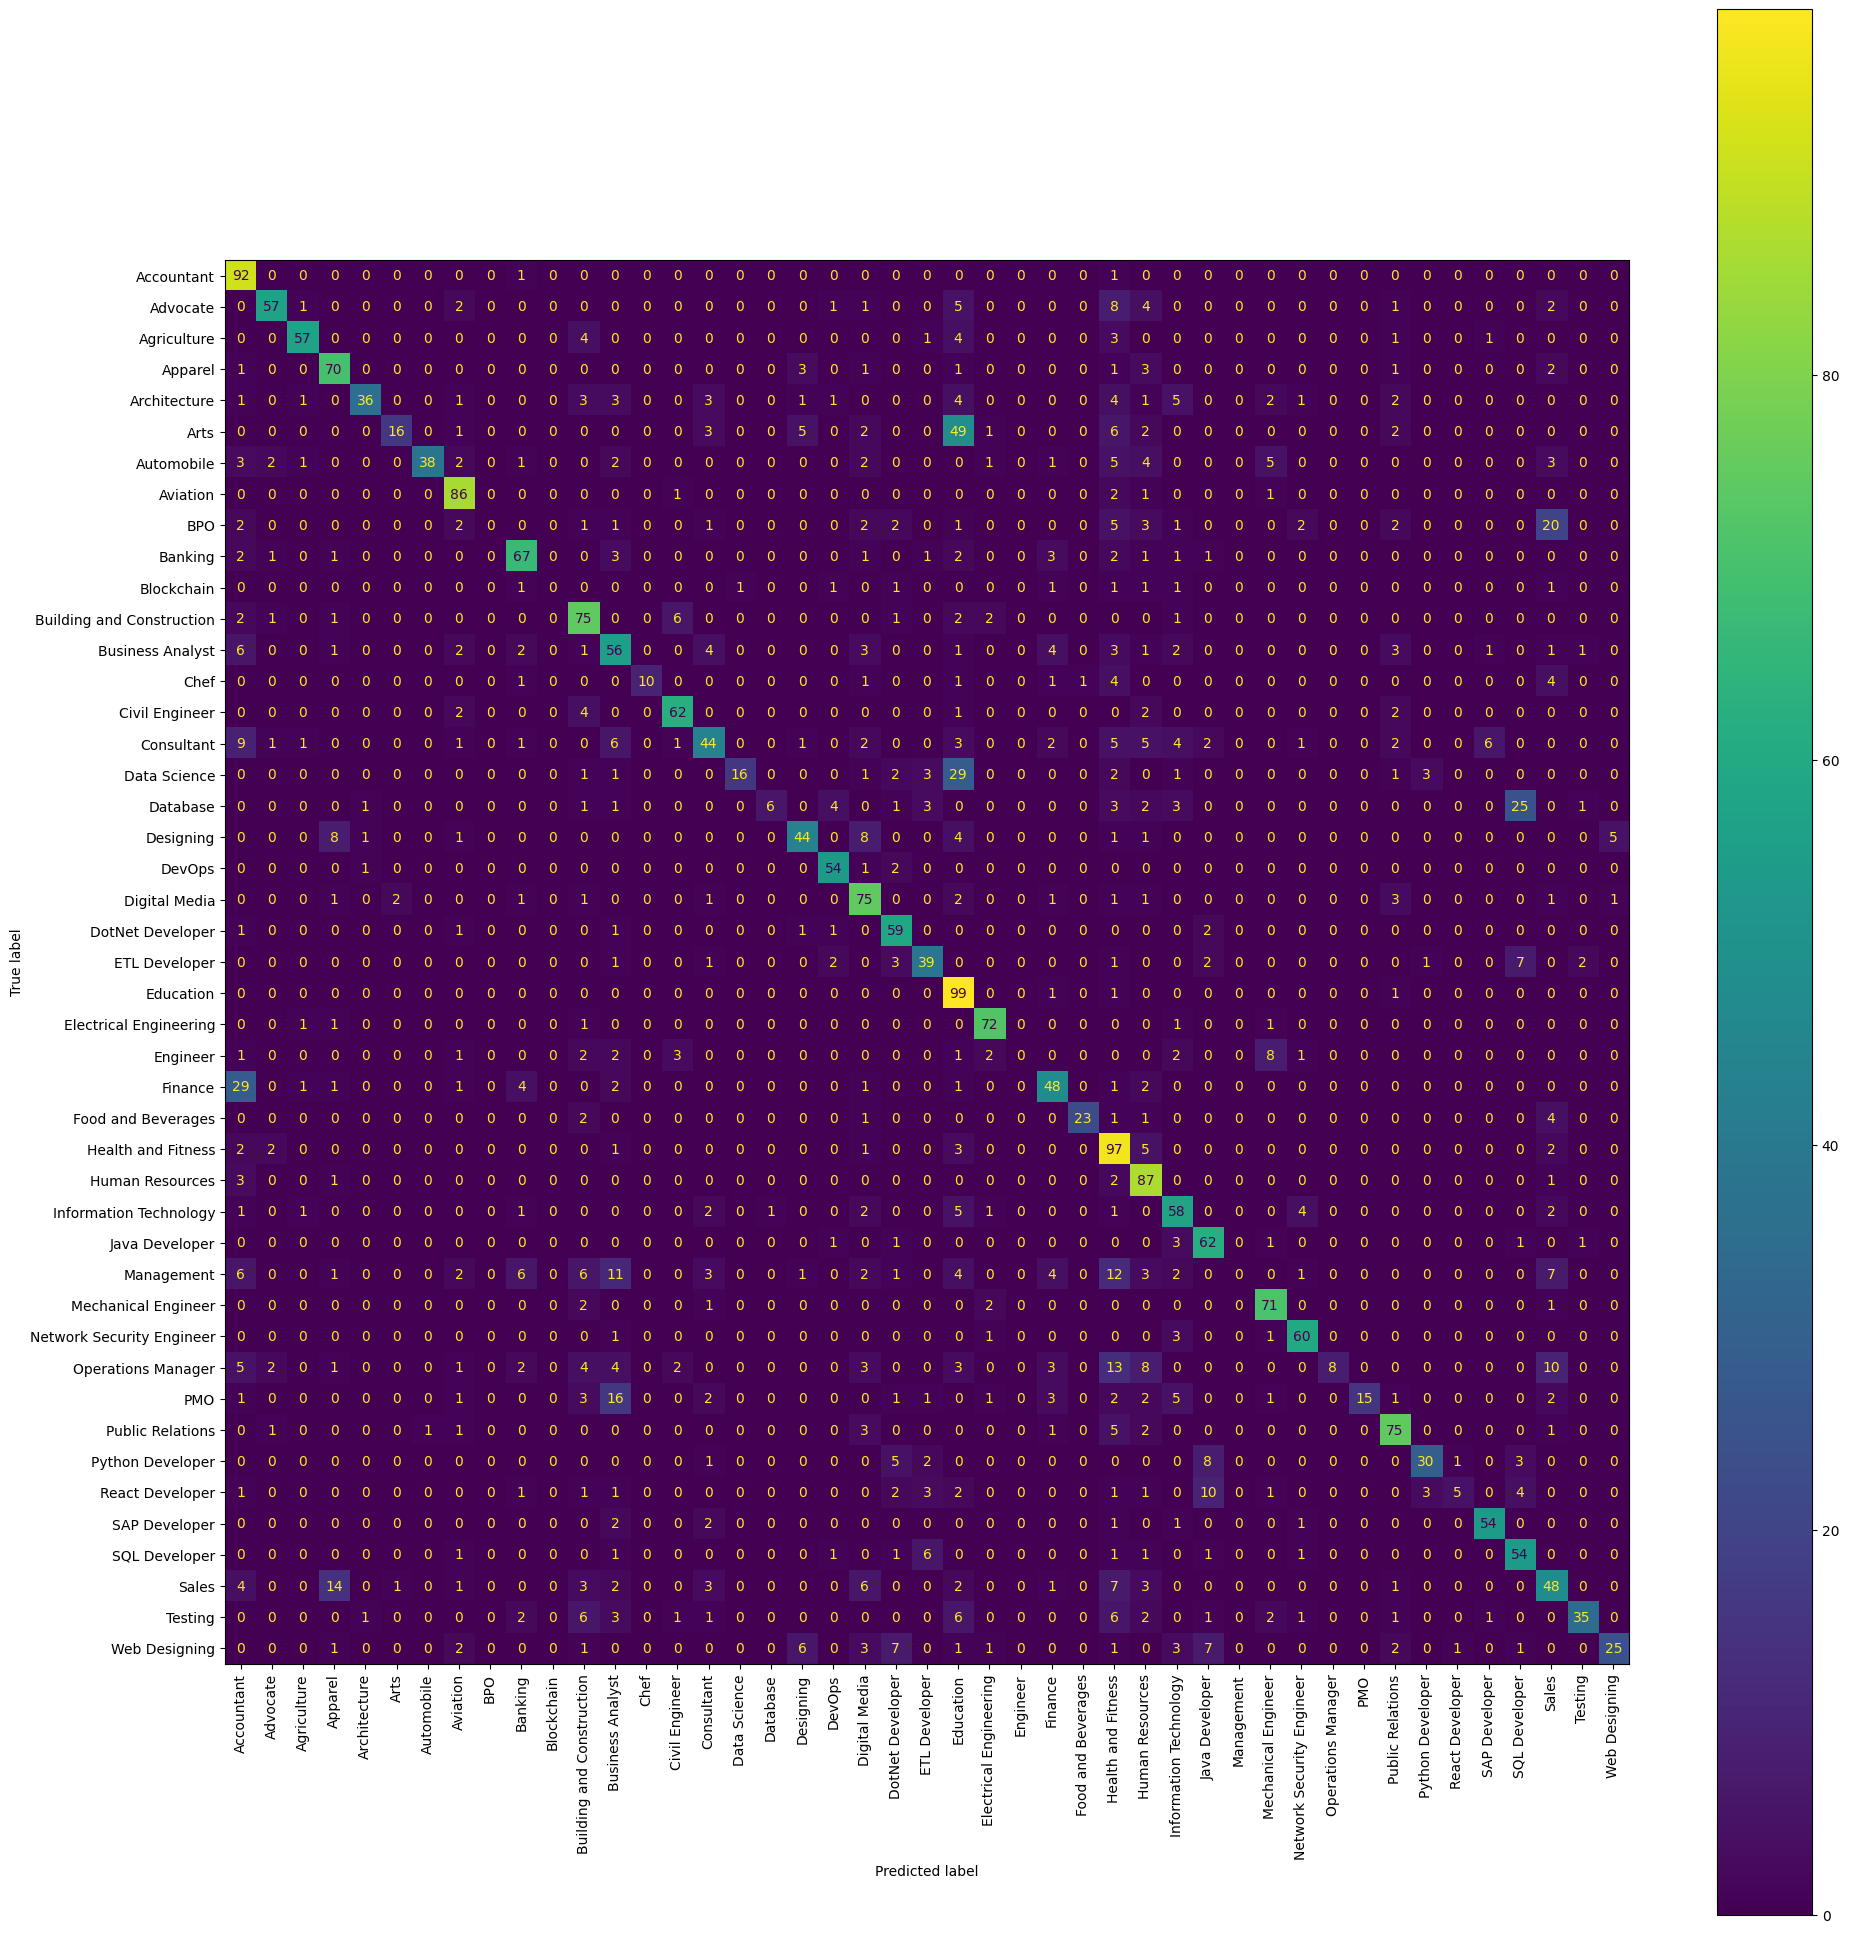

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))  # Modifica il valore per un grafico più grande

# Creazione della matrice di confusione
ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, values_format=".0f")

# Miglioramento della leggibilità
plt.xticks(fontsize=10, rotation=90)  # Ruota le etichette se sono troppe
plt.yticks(fontsize=10)
plt.tight_layout()  # Ottimizza la disposizione degli elementi

# Salvataggio con alta risoluzione
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

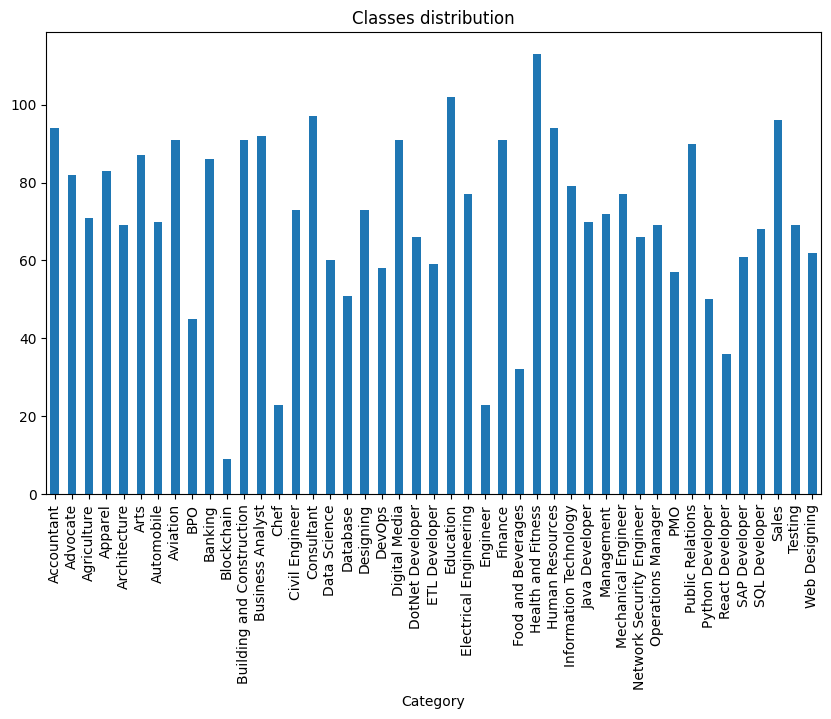

In [17]:
y_test.value_counts().sort_index().plot(kind='bar', title='Classes distribution', figsize=(10,6))
plt.show()